## TODO: Set up initial framework for L2L-Arbor connection:

1. ✅ Created ArborOptimizee class, which implements the L2L interface
2. ✅ Defined parameter space management
3. ✅ Implemented simulation and evaluation functionality
4. ✅ Created optimization tracing and visualization
5. ✅ Completed basic random search tests

Next TODO:
- Integrate a true L2L optimizer (GA, MCMC, etc.)
- Add more ion channel parameters
- Improve fitness function
- Implement parallelization

# 1. L2L-Arbor Prototype Connector

This notebook demonstrates how to connect the L2L optimization framework to the Arbor neural simulator. 

## 1.1 Installing dependencies

First make sure that the necessary dependency packages are installed:

In [12]:
# basic
# !pip install arbor==0.11 numpy pandas matplotlib seaborn

# L2L
# !pip install git+https://github.com/Meta-optimization/L2L.git

## 1.2 Importing necessary libraries

In [13]:
import arbor as A
from arbor import units as U
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1.3 Create the Arbor Optimizee class

This is the core interface between L2L and Arbor. Optimizee is a concept in the L2L framework that represents the system to be optimized.

In [14]:
class ArborOptimizee:
    """Arbor Cell Model as Optimizee for L2L"""
    
    def __init__(self, morphology_file: str, reference_data: pd.DataFrame, 
                 stimulus_protocol: Dict, dt: float = 0.005):
        """
        Initialize Arbor optimizee
        
        Args:
            morphology_file: SWC morphology file path
            reference_data: Reference membrane potential data
            stimulus_protocol: Stimulus protocol configuration
            dt: time step (ms)
        """
        self.morphology_file = morphology_file
        self.reference_data = reference_data
        self.stimulus_protocol = stimulus_protocol
        self.dt = dt
        
        # Load morphology
        self.load_morphology()
        
        # Parameter bounds (to be defined later)
        self.parameter_bounds = {}
        
    def load_morphology(self):
        """Load cell morphology"""
        raw = A.load_swc_neuron(self.morphology_file)
        self.morphology = raw.morphology
        self.labels = raw.labels
        self.labels.add_swc_tags()
        logger.info(f"Loading morphology file: {self.morphology_file}")
        
    def create_cell(self, parameters: Dict) -> A.cable_cell:
        """Create cell model based on parameters"""
        decor = A.decor()
        
        # Set global properties
        decor.set_property(
            tempK=parameters.get('temperature', 34) * U.Celsius,
            Vm=parameters.get('v_init', -65) * U.mV,
            cm=parameters.get('cm', 1.0) * U.uF / U.cm2,
            rL=parameters.get('rL', 100) * U.Ohm * U.cm
        )
        
        # Add ion channels (simplified version)
        # This needs to be dynamically configured according to actual parameters
        decor.paint('"soma"', A.density('pas'))
        
        # Add stimulus
        stim = self.stimulus_protocol
        decor.place(
            '(location 0 0.5)', 
            A.iclamp(
                stim['delay'] * U.ms,
                stim['duration'] * U.ms,
                stim['amplitude'] * U.pA
            ),
            "stimulus"
        )
        
        # Create cell
        return A.cable_cell(self.morphology, decor, self.labels)
    
    def simulate(self, parameters: Dict) -> Tuple[np.ndarray, np.ndarray]:
        """Run simulation and return results"""
        cell = self.create_cell(parameters)
        
        # Create single-cell recipe
        class single_recipe(A.recipe):
            def __init__(self, cell):
                A.recipe.__init__(self)
                self.the_cell = cell
                self.the_prop = A.neuron_cable_properties()
                self.the_prop.catalogue.extend(A.allen_catalogue(), '')
                
            def num_cells(self):
                return 1
            
            def cell_kind(self, gid):
                return A.cell_kind.cable
            
            def cell_description(self, gid):
                return self.the_cell
            
            def global_properties(self, kind):
                return self.the_prop
            
            def probes(self, gid):
                return [A.cable_probe_membrane_voltage('(location 0 0.5)', 'Um')]
        
        # Run simulation
        recipe = single_recipe(cell)
        sim = A.simulation(recipe)
        handle = sim.sample((0, 'Um'), A.regular_schedule(self.dt * U.ms))
        
        tfinal = self.stimulus_protocol.get('tfinal', 1400)
        sim.run(tfinal * U.ms, self.dt * U.ms)
        
        # Extract results
        for data, meta in sim.samples(handle):
            time = data[:, 0]
            voltage = data[:, 1]
            
        return time, voltage
    
    def evaluate(self, parameters: Dict) -> float:
        """Evaluate fitness of parameter set"""
        try:
            time, voltage = self.simulate(parameters)
            
            # Calculate error with reference data
            # Simple mean squared error is used here, can be improved later
            ref_voltage = np.interp(time, self.reference_data.index, 
                                  self.reference_data['U/mV'])
            
            mse = np.mean((voltage - ref_voltage) ** 2)
            
            return -mse  # L2L usually maximizes fitness, so return negative MSE
            
        except Exception as e:
            logger.error(f"Simulation failed: {e}")
            return -np.inf  # Return very low fitness

## 1.4 Create parameter space definition

In [15]:
@dataclass
class ParameterRange:
    """Parameter range definition"""
    name: str
    min_value: float
    max_value: float
    unit: str = ""
    
class ParameterSpace:
    """Parameter space manager"""
    
    def __init__(self):
        self.parameters = []
        
    def add_parameter(self, name: str, min_val: float, max_val: float, unit: str = ""):
        """Add parameter to search space"""
        self.parameters.append(ParameterRange(name, min_val, max_val, unit))
        
    def sample_random(self) -> Dict[str, float]:
        """Randomly sample a set of parameters"""
        return {p.name: np.random.uniform(p.min_value, p.max_value) 
                for p in self.parameters}
    
    def get_bounds(self) -> List[Tuple[float, float]]:
        """Get parameter bounds (for optimizer)"""
        return [(p.min_value, p.max_value) for p in self.parameters]
    
    def visualize(self):
        """Visualize parameter space"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        y_pos = np.arange(len(self.parameters))
        names = [p.name for p in self.parameters]
        ranges = [(p.max_value - p.min_value) for p in self.parameters]
        mins = [p.min_value for p in self.parameters]
        
        bars = ax.barh(y_pos, ranges, left=mins, alpha=0.7)
        
        # Add labels
        for i, (p, bar) in enumerate(zip(self.parameters, bars)):
            ax.text(p.min_value - 0.1, i, f'{p.min_value:.2f}', 
                   ha='right', va='center')
            ax.text(p.max_value + 0.1, i, f'{p.max_value:.2f}', 
                   ha='left', va='center')
            if p.unit:
                names[i] += f' ({p.unit})'
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(names)
        ax.set_xlabel('Parameter Value')
        ax.set_title('Parameter Search Space')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

## 1.5 Test basic connection

In [16]:
# Load reference data
ref_data = pd.read_csv('single_cell_allen_neuron_ref.csv', usecols=[1,2], index_col=0)
with open('single_cell_allen_fit.json') as fd:
    fit_data = json.load(fd)

# Adjust reference data
ref_data['U/mV'] *= 1000.0
ref_data['U/mV'] += fit_data["fitting"][0]["junction_potential"]

# Define stimulus protocol
stimulus = {
    'delay': 200,      # ms
    'duration': 1000,  # ms
    'amplitude': 150,  # pA
    'tfinal': 1400     # ms
}

# Create optimizee
optimizee = ArborOptimizee(
    morphology_file='single_cell_allen.swc',
    reference_data=ref_data,
    stimulus_protocol=stimulus
)

print("✓ Optimizee created successfully")

INFO:__main__:Loading morphology file: single_cell_allen.swc


✓ Optimizee created successfully


## 1.6 Define parameter space and visualize

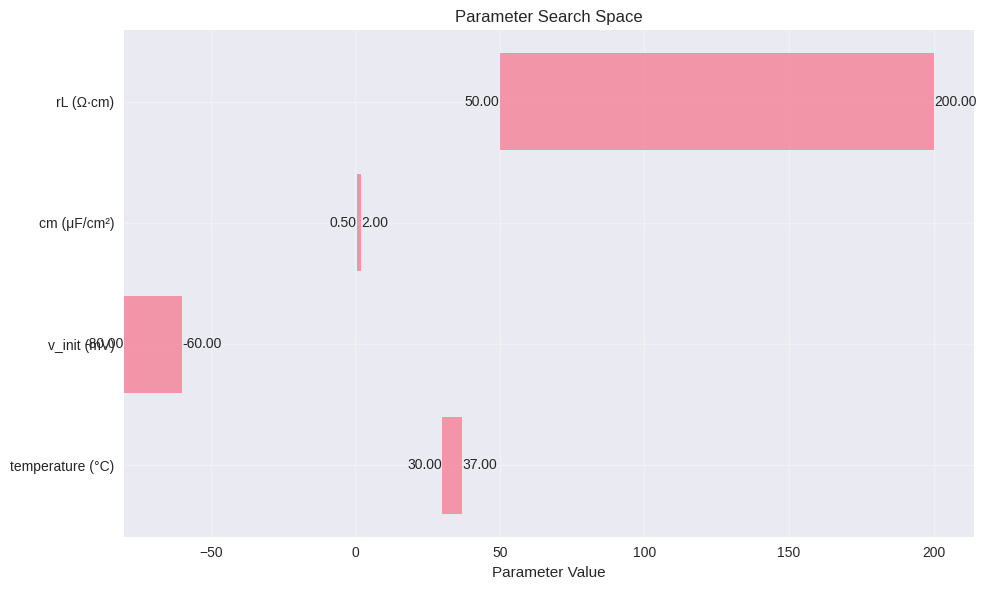


Random parameter sample:
  temperature: 34.010
  v_init: -74.437
  cm: 0.826
  rL: 163.537


In [17]:
# Create parameter space
param_space = ParameterSpace()

# Add basic physiological parameters
param_space.add_parameter('temperature', 30, 37, '°C')
param_space.add_parameter('v_init', -80, -60, 'mV')
param_space.add_parameter('cm', 0.5, 2.0, 'μF/cm²')
param_space.add_parameter('rL', 50, 200, 'Ω·cm')

# Visualize parameter space
param_space.visualize()
plt.show()

# Test random sampling
sample_params = param_space.sample_random()
print("\nRandom parameter sample:")
for k, v in sample_params.items():
    print(f"  {k}: {v:.3f}")

## 1.7 Run single simulation test

Running test simulation...


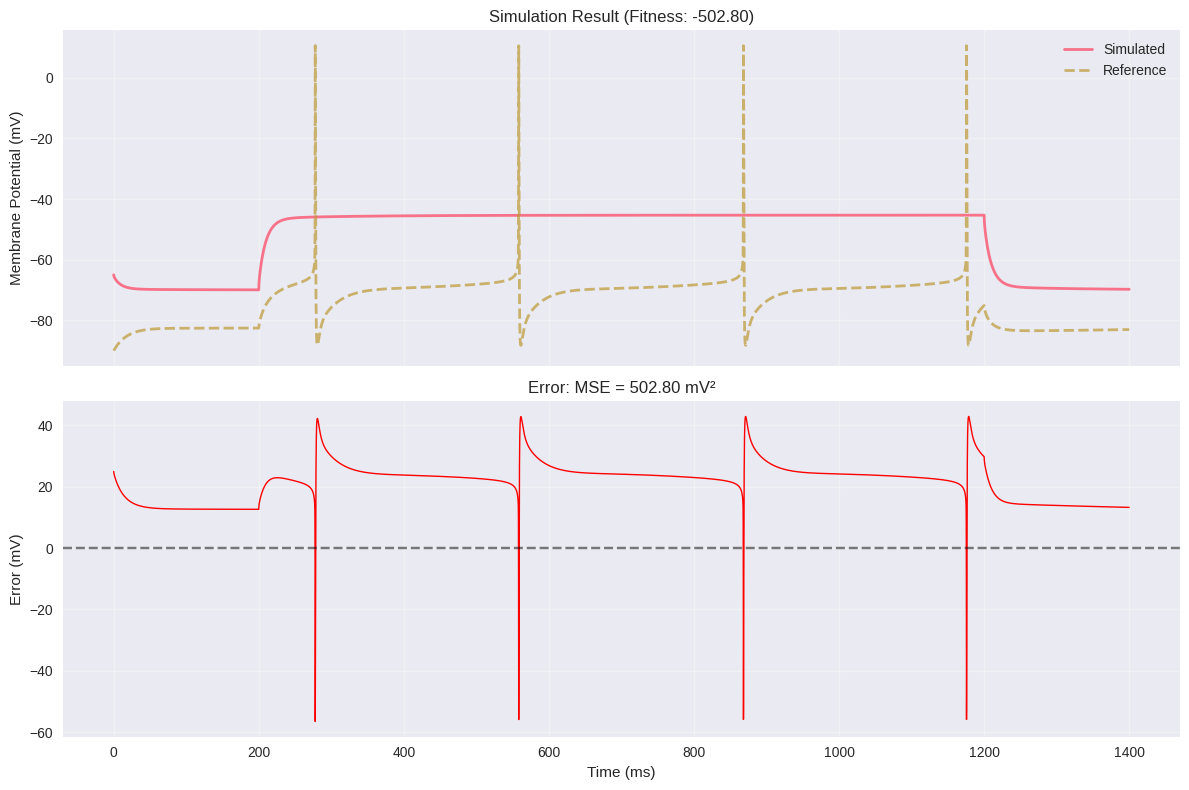


✓ Test completed! Fitness: -502.80


In [18]:
# Run simulation with default parameters
default_params = {
    'temperature': 34,
    'v_init': -65,
    'cm': 1.0,
    'rL': 100
}

print("Running test simulation...")
time, voltage = optimizee.simulate(default_params)
fitness = optimizee.evaluate(default_params)

# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Membrane potential comparison
ax1.plot(time, voltage, label='Simulated', linewidth=2)
ax1.plot(ref_data.index, ref_data['U/mV'], label='Reference', 
         linewidth=2, alpha=0.7, linestyle='--')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title(f'Simulation Result (Fitness: {fitness:.2f})')

# Error
ref_interp = np.interp(time, ref_data.index, ref_data['U/mV'])
error = voltage - ref_interp
ax2.plot(time, error, color='red', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Error (mV)')
ax2.grid(True, alpha=0.3)
ax2.set_title(f'Error: MSE = {np.mean(error**2):.2f} mV²')

plt.tight_layout()
plt.show()

print(f"\n✓ Test completed! Fitness: {fitness:.2f}")

## 1.8 Create optimizer interface

In [19]:
class OptimizationTracker:
    """Track optimization process"""
    
    def __init__(self):
        self.history = []
        self.best_params = None
        self.best_fitness = -np.inf
        
    def update(self, generation: int, params: Dict, fitness: float):
        """Update optimization history"""
        self.history.append({
            'generation': generation,
            'params': params.copy(),
            'fitness': fitness
        })
        
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_params = params.copy()
            
    def plot_convergence(self):
        """Plot convergence curve"""
        if not self.history:
            print("No optimization history available")
            return
            
        generations = [h['generation'] for h in self.history]
        fitness_values = [h['fitness'] for h in self.history]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(generations, fitness_values, 'b-', alpha=0.6, label='All evaluations')
        
        # Mark best point
        best_idx = np.argmax(fitness_values)
        ax.plot(generations[best_idx], fitness_values[best_idx], 
               'r*', markersize=15, label='Best')
        
        ax.set_xlabel('Generation')
        ax.set_ylabel('Fitness')
        ax.set_title('Optimization Convergence')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Create tracker instance
tracker = OptimizationTracker()
print("✓ Optimization tracker created")

✓ Optimization tracker created


## 1.9 Simple optimization example (random search)

In [20]:
# Run simple random search as proof of concept
n_iterations = 10
print(f"Running {n_iterations} random searches...\n")

for i in range(n_iterations):
    # Randomly sample parameters
    params = param_space.sample_random()
    
    # Evaluate
    fitness = optimizee.evaluate(params)
    
    # Update tracker
    tracker.update(i, params, fitness)
    
    print(f"Iteration {i+1}/{n_iterations}: Fitness = {fitness:.2f}")
    
    # Show current best
    if fitness == tracker.best_fitness:
        print("  🌟 New best parameters!")

print(f"\nBest fitness: {tracker.best_fitness:.2f}")
print("Best parameters:")
for k, v in tracker.best_params.items():
    print(f"  {k}: {v:.3f}")

Running 10 random searches...

Iteration 1/10: Fitness = -500.87
  🌟 New best parameters!
Iteration 2/10: Fitness = -497.92
  🌟 New best parameters!
Iteration 3/10: Fitness = -492.81
  🌟 New best parameters!
Iteration 4/10: Fitness = -501.75
Iteration 5/10: Fitness = -499.50
Iteration 6/10: Fitness = -503.09
Iteration 7/10: Fitness = -501.11
Iteration 8/10: Fitness = -492.65
  🌟 New best parameters!
Iteration 9/10: Fitness = -498.87
Iteration 10/10: Fitness = -499.70

Best fitness: -492.65
Best parameters:
  temperature: 36.114
  v_init: -79.354
  cm: 1.721
  rL: 106.577


## 1.10 Visualize optimization results

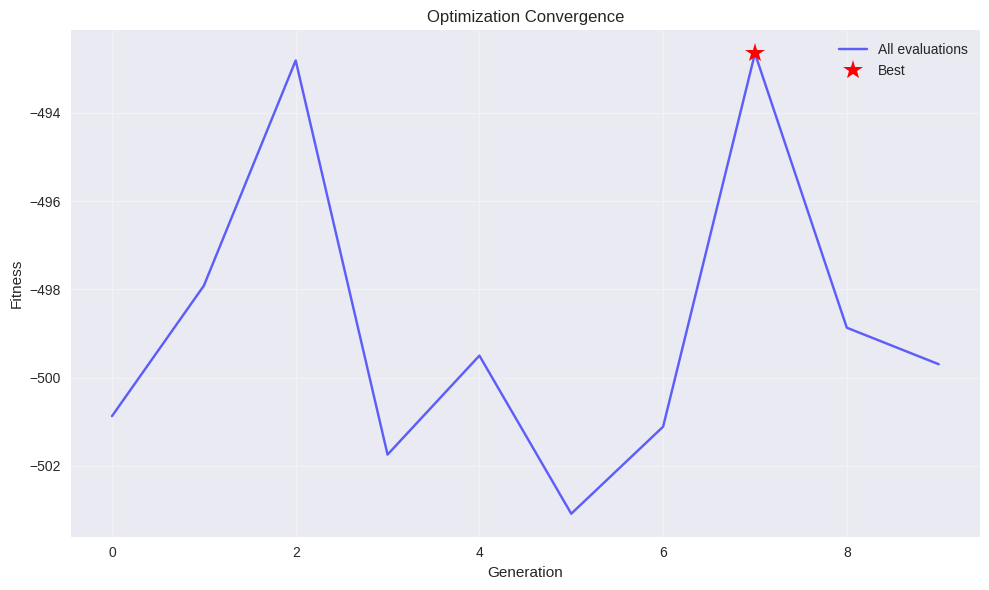


Running simulation with best parameters...


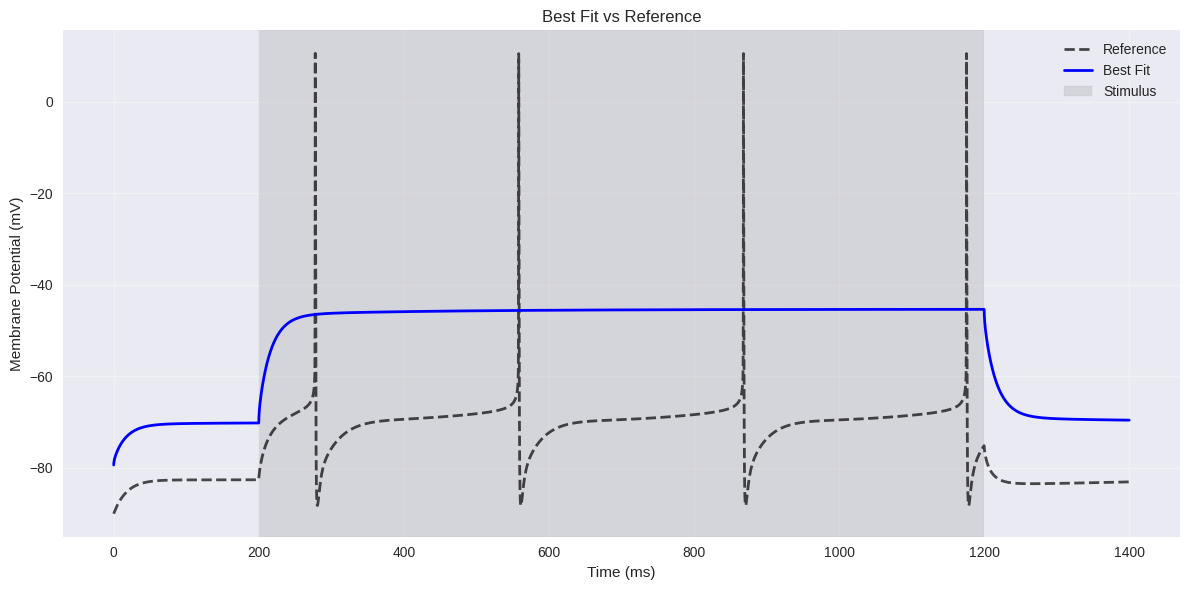

In [21]:
# Plot convergence curve
tracker.plot_convergence()
plt.show()

# Run simulation with best parameters
print("\nRunning simulation with best parameters...")
best_time, best_voltage = optimizee.simulate(tracker.best_params)

# Compare best result vs reference
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ref_data.index, ref_data['U/mV'], 'k--', 
        linewidth=2, alpha=0.7, label='Reference')
ax.plot(best_time, best_voltage, 'b-', 
        linewidth=2, label='Best Fit')

# Add stimulus indicator
stim_start = stimulus['delay']
stim_end = stimulus['delay'] + stimulus['duration']
ax.axvspan(stim_start, stim_end, alpha=0.2, color='gray', label='Stimulus')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane Potential (mV)')
ax.set_title('Best Fit vs Reference')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()